## OASIS - Demonstration notebook - Single day simulation
*V1.0.0 August 2023*

This notebook walks through a simulation run using OASIS. The simulator takes as input a set of activities to be scheduled, travel times and utility parameters and outputs optimised schedules. 

Note that this notebook requires the [docplex library](https://pypi.org/project/docplex/) with a valid [CPLEX license](https://www.ibm.com/docs/en/icos/20.1.0?topic=cplex-setting-up-python-api) to run. 

You can find the full documentation [here](https://oasis-abm.readthedocs.io/en/latest/), and the companion paper [here](https://www.sciencedirect.com/science/article/pii/S0968090X23002802#d1e7373).


### Main files

The following files are used for the simulation.

- ``simulation.py``: This script stores information on the ``Simulation`` class and subclasses (e.g.``MIP``). These classes are used to set up and solve the optimisation problem.
- ``results.py``: The ``Results`` class stores the outputs of the simulation (optimised schedules, runtimes, and objective functions), and handles the visualisation and simulation statistics.
- ``input_data.py``: This script handles the input data, and creates ``ActivityData`` objects. These objects contain information on each activity to be scheduled, including preferred start time, duration, and utility parameters.
- ``error_terms.py``: The ``ErrorTerms`` class is used to handle the utility function errors -- to be drawn at each new iterations.
- ``runner.py``: The main file to run the simulation.

In addition, we have provided a small example to illustrate the implemented functions. They are stored in the ``data/`` folder.


In [1]:
import math
import shutil
import joblib
import json
import pandas as pd
import oasisabm as as

from oa.input_data import data_reader
from oa.error_terms import GaussianError, EVError
from oa.simulation import MIP


### Preparing the input

There are three main inputs that must be provided for the simulation: 

- The set of activities (``DATA``)
- A mode travel time matrix (``TT``)
- The set of activity parameters (``PARAMS``)


In [2]:
DATA = joblib.load('data/example_data.joblib')
TT = joblib.load('data/example_tt.joblib')
PARAMS = json.load(open('data/example_parameters.json', 'r'))

Let's examine ``DATA``. 

This schedule contains two *work* activities and a *leisure* activities. The set of activities is provided as a ``pandas DataFrame``, and contains the label of the activities (a unique identifier and the activity type), a feasible start and end time (not mandatory, and will default to the full day if not provided), the location of the activity, the mode of transportation and desired start and end times. Note that the location and mode should exist as keys in the travel time matrix.

In [3]:
DATA

act_id act_label    label  feasible_start  feasible_end location  \
0     1.0      home     dawn               0            24        A   
1     2.0      work    work1               5            23        B   
2     1.0      home     home               0            24        A   
3     2.0      work    work2               5            23        B   
4     8.0   leisure  leisure               0            24        B   
5     1.0      home     dusk               0            24        A   

  mode_travel    group  desired_start  desired_duration  
0     driving     dawn       0.000000         12.940332  
1     driving     work       6.602686         10.470977  
2     driving     home       0.000000         12.940332  
3     driving     work       6.602686         10.470977  
4     driving  leisure      16.005231          3.380537  
5     driving     dusk       0.000000         12.940332

The travel time matrix is a dictionary formatted as:

``{mode: {
origin_location: {
destination_location1 : travel_time_1,
destination_location2 : travel_time_2
}}}``

The travel time is in hours. In this example, we consider the travel times for the *driving* mode and two different locations.


In [4]:
TT

{'driving': {'A': {'A': 0, 'B': 0.0002777777777777778},
  'B': {'A': 0.0002777777777777778, 'B': 0}}}

Finally, the parameters should be a dictionary containing the activity-specific parameters that will be used in the utility function. The dictionary should have the format: 

``
{activity_1: {parameter_1: value, parameter_2: value},
 activity_2: {parameter_1: value, parameter_2:value}}
``

In this example, we use the default OASIS utility function (see technical report for details), including penalties for early and late start time, short and long duration, and travel time. The parameters for the *work* activity are:

In [5]:
PARAMS['work']

{'constant': 13.0838530926,
 'early': -0.618657816,
 'late': -0.3384943975,
 'short': -0.9319615942,
 'long': -1.223996357,
 'travel_time': -1}

The next step is to define the error terms that will be used in the utility function. In the default specification (see technical reports for details), we consider normally distributed error terms for each decision variable, and an Extreme Value distributed error term. 

These random components are instances of the ``ErrorTerms`` class, and are defined in a dedicated dictionary ``UTILITY_PARAMS``. During the simulation the ``draw()`` method of these error objects will be called to draw a new value for each iteration. 

In [6]:
UTILITY_PARAMS = {
    'error_w': GaussianError(),
    'error_x': GaussianError(),
    'error_d': GaussianError(),
    'error_z': GaussianError(),
    'error_ev': EVError()
    }

print(UTILITY_PARAMS["error_ev"].loc, UTILITY_PARAMS["error_ev"].scale)

0 1


Finally, we call the ``data_reader()`` function, which transforms the schedule dataframe and parameters into ``ActivityData`` objects that will be used during the simulation. 

In [7]:
dataset = data_reader(DATA,PARAMS)

### Setting up and running the model

Once the data is imported, we can set up the simulation model. This is done by creating a ``Simulation`` object, and passing the dataset, the utility function parameters and the parameters of the simulation (number of iterations, and progress output) as arguments. The ``verbose`` argument specifies how frequently the model prints its progress.

Each new ``Simulation`` object instantiates a ``Model`` from the ``docplex`` library. The method ``initialize()`` adds decision variables and constraints to the model, and can be modified directly in the corresponding script, or using the ``add\_constraints()`` function in the runner file. The CPLEX optimisation settings (e.g. time limit) can be specified when creating the ``Simulation``. The default settings are a time limit of 120 seconds per solve call, and the optimality target set to ``global`` (See [IBM's documentation](https://www.ibm.com/docs/en/icos/20.1.0?topic=cplex-list-parameters)for an exhaustive list of parameters)

The utility and objective functions of the problem can be directly modified in the ``utility_function`` and ``objective_function()`` methods of the ``Simulation`` object. 

The ``run()`` method solves the optimisation problem, and returns a ``Results`` object containing the optimised schedule(s), the runtime(s) and the value(s) of objective function.

Here, we create a simulation with 100 iterations and a MIP solver. We print the model progress every 25 iterations.



In [8]:
N_ITER = 100

new_simulation = MIP(dataset, UTILITY_PARAMS,TT)

results = new_simulation.run(n_iter = N_ITER, verbose = 25)

Starting simulation: 100 iterations.
-----------------------------------------
Starting iteration 25/100.
Iteration 25 complete. Iteration runtime: 00:00:00. Time elapsed: 00:00:27.
Starting iteration 50/100.
Iteration 50 complete. Iteration runtime: 00:00:02. Time elapsed: 00:01:00.
Starting iteration 75/100.
Iteration 75 complete. Iteration runtime: 00:00:00. Time elapsed: 00:01:36.
Starting iteration 100/100.
Iteration 100 complete. Iteration runtime: 00:00:00. Time elapsed: 00:02:02.
-----------------------------------------
Simulation complete. Total runtime: 00:02:02


### Processing the outputs


The simulation outputs a ```Results``` object, that stores the optimal schedules, runtimes and objective values for all iterations. Several methods can be helpful to visualise the results: 

- ``plot()``: plots the optimal schedules. The argument ``plot_every`` controls how many schedules to plot if more than one is provided. By default, the figure is saved as a ``png`` file, but this can be modified with the ``save_fig`` argument (either saving with a different extension or not saving the figure). The plotting function can be further customised by specifying for example the size, title, the legend or the activity colors.


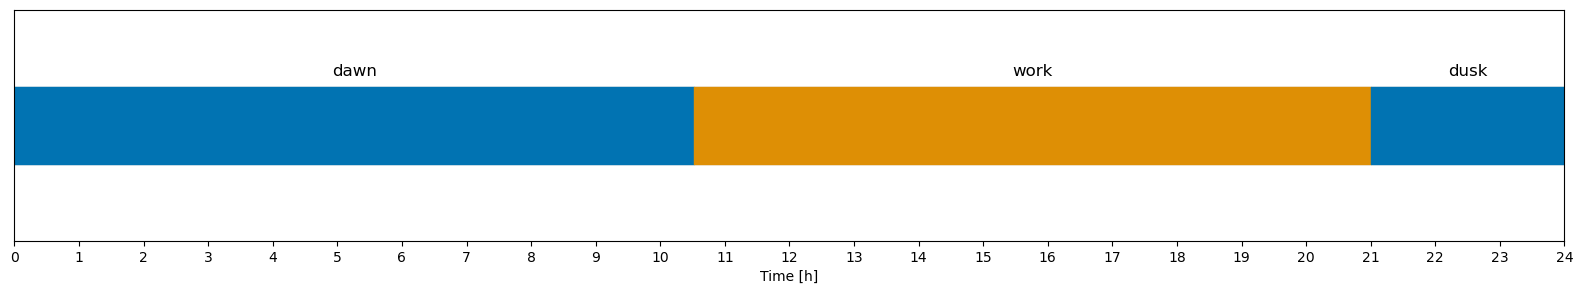

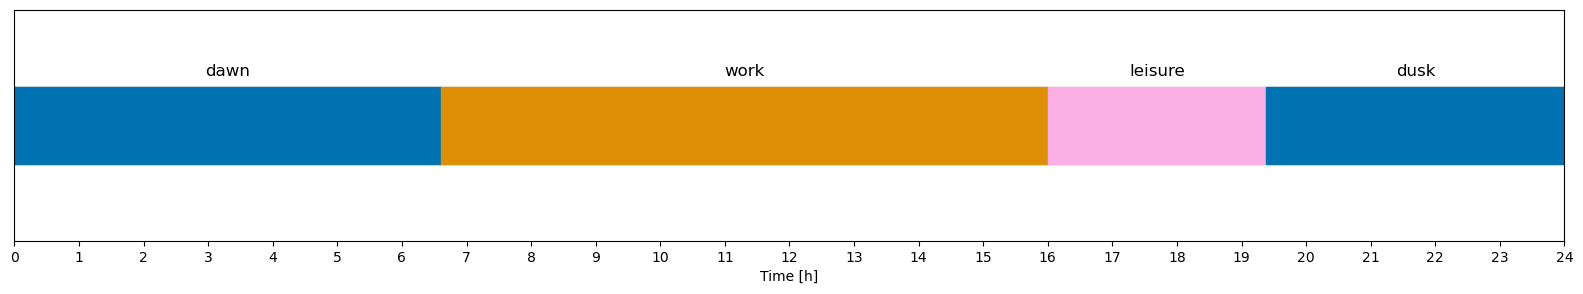

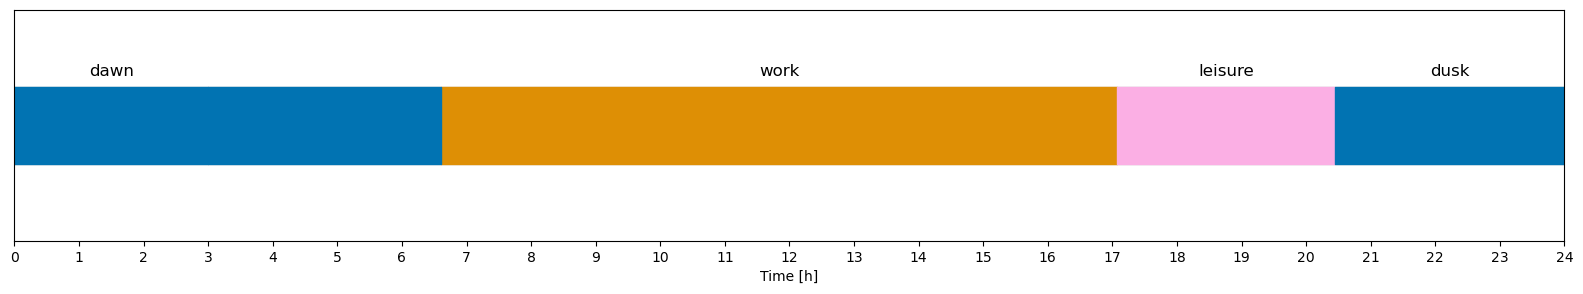

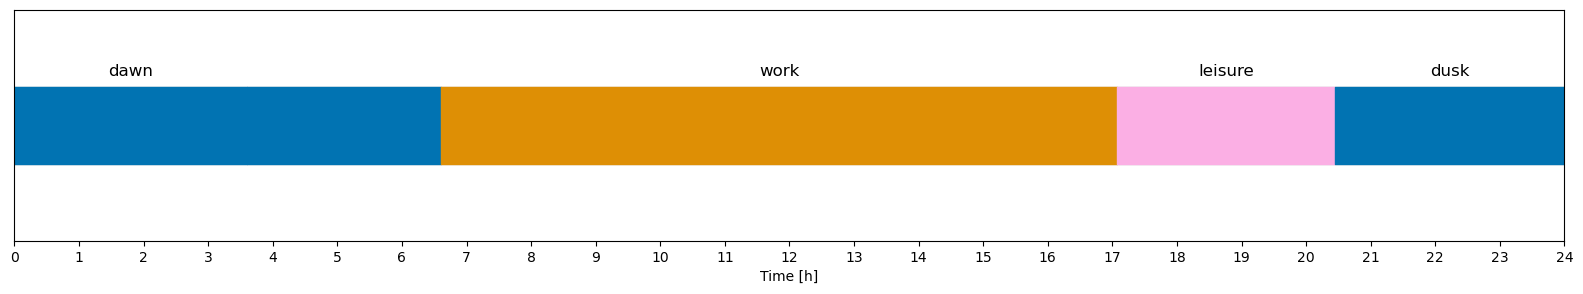

In [9]:
results.plot(plot_every=25, save_fig= False)

- ``plot_distribution():`` plots the time of day distribution across all iterations. By default, the figure is saved as a ``png`` file, but this can be modified with the ``save_fig`` argument (either saving with a different extension or not saving the figure). The plotting function can be further customised by specifying for example the size, title, the legend or the activity colors.

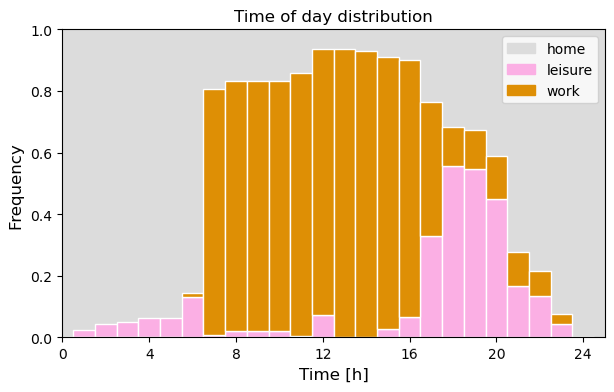

In [10]:
results.plot_distribution(figure_size= [7,4], save_fig=False)


- ``compute_statistics()``: computes simulation statistics (e.g. proportion of out-of-home schedules, average time spent in a given activity) for a given list of activities. These statistics can be directly printed or saved to a file. This function provides bootsrap confidence intervals for each indicator. The settings for the bootstrapping can be specified in the arguments (e.g. number of samples, level of confidence).

In [11]:
results.compute_statistics(['home', 'work', 'leisure'], save = False)

Summary of collected statistics:
------------------------------------------------

Total number of schedules: 100
Proportion of out-of-home schedules: 95.00 %
Average time spent out-of-home: 12.45, CI: [12.168,12.659] hours
Average number of out-of-home activities: 1.92, CI: [1.905, 1.937]
------------------------------------------------

Average duration of each activity:
Home: 11.55, CI: [11.274, 11.747] hours
Work: 10.03, CI: [9.921, 10.121] hours
Leisure: 2.97, CI: [2.854, 3.042] hours
------------------------------------------------

